<a href="https://colab.research.google.com/github/Elysian-C/Crypto-social-media-visualizations/blob/main/Adquisici%C3%B3n_de_datos_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TRABAJO PARCIAL**

> Curso: MACHINE LEARNING

> Tema: Verificación de la Popularidad del token

> Integrantes:
* Cano Chocce, Samuel Esteban –  U202116508
* Guerrero Icochea, Nicolas Miguel – U202115535
* Puglisevich Vergara, Eduardo Elias – U20201E850


> Seccion: CC72

In [ ]:
#@title Importamos librerias
!pip install praw
!pip install ntscraper
from bs4 import BeautifulSoup
from requests import Request, Session, get
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import pandas as pd
import numpy as np
import re
from ntscraper import Nitter
import praw
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap


#API KEY de CoinMarketCap
API_KEY_CMC = 'd289910c-613c-41dc-9481-af80cbb47102'
#URL para la extracción por web scrapping
URL_BASE = "https://coinmarketcap.com/es/currencies/"
#Scrapper para la extracción de twitter
SCRAPER = Nitter()

## **Extracción de datos por medio de API de CoinMarketCap**

### Definimos funciones de extracción de datos mediante el API de CoinMarketCap

In [ ]:
def requestCategories(s = 1, l = 5000):
  url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/categories"
  parameters = {
      "start": s,
      "limit": l,
  }
  headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': API_KEY_CMC,
  }

  session = Session()
  session.headers.update(headers)

  try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    return data
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)
    return 0

def requestTokensXCategory(category,s = 1, l = 1000):
  url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/category"
  parameters = {
      "id":category,
      "start": s,
      "limit": l,
  }
  headers = {
    'Accepts': 'application/json',
    'X-CMC_PRO_API_KEY': API_KEY_CMC,
  }

  session = Session()
  session.headers.update(headers)

  try:
    response = session.get(url, params=parameters)
    data = json.loads(response.text)
    return data
  except (ConnectionError, Timeout, TooManyRedirects) as e:
    print(e)

def extractCategories(data, categories = set(), info = set()):  ## Las categorias deben estar igualmente escritas que en la web de CoinMarketCap // la info debe estar en minuscula
  dictData = dict()
  for d in data["data"]:
    if len(categories) == 0:
      flag = 1
    else:
      flag = 0
      for c in categories:
        if c in  d["name"]:
          flag = 1
    if flag:
      dictData[d["id"]] = dict()
      dictData[d["id"]]["name"] = d["name"]
      for i in info:
        if i != "name" and i != "id" :
          dictData[d["id"]][i]=d[i]
  return dictData

def extractTokens(data, tokens = set(), info = set()):  ## Los tokens deben estar igualmente escritas que en la web de CoinMarketCap // la info debe estar en minuscula
  dictData = dict()
  for d in data["data"]["coins"]:
    if len(tokens) == 0:
      flag = 1
    else:
      flag = 0
      for c in tokens:
        if c in  d["name"]:
          flag = 1
    if flag:
      dictData[d["id"]] = dict()
      dictData[d["id"]]["name"] = d["name"]
      for i in info:
        if i != "name" and i != "id" :
          dictData[d["id"]][i]=d[i]
  return dictData
def dictToList(d,cat):
  lista = []
  for k1, v1 in d.items():
    aux = [k1]
    aux.extend(v2 for k2,v2 in v1.items())
    aux.append(cat)
    lista.append(aux)
  return lista

### Aplicamos nuestras funciones implementadas

In [ ]:
#@title Extracción de categorías
CategoriesData = requestCategories()
CAT = extractCategories(CategoriesData,{"Memes","AI","Real World","Gaming"},{"num_tokens"})
CAT

{'6604f2405726cb6104472fdb': {'name': 'Presale Memes', 'num_tokens': 3},
 '6400b58c1701313dc2e853a9': {'name': 'Real World Assets', 'num_tokens': 137},
 '63ff40541701313dc2e81ead': {'name': 'Generative AI', 'num_tokens': 85},
 '6192765a2696b919a04444ea': {'name': 'Gaming Guild', 'num_tokens': 19},
 '6051a82566fc1b42617d6dc6': {'name': 'Memes', 'num_tokens': 2195},
 '6051a82166fc1b42617d6dc1': {'name': 'Gaming', 'num_tokens': 678},
 '6051a81a66fc1b42617d6db7': {'name': 'AI & Big Data', 'num_tokens': 298}}

In [ ]:
#@title Extracción de tokens
GamingTokens = requestTokensXCategory("6051a82166fc1b42617d6dc1",l=CAT['6051a82166fc1b42617d6dc1']["num_tokens"])
AITokens = requestTokensXCategory("6051a81a66fc1b42617d6db7",l=CAT['6051a81a66fc1b42617d6db7']["num_tokens"])
RWATokens = requestTokensXCategory("6400b58c1701313dc2e853a9",l=CAT['6400b58c1701313dc2e853a9']["num_tokens"])
MemeTokens1 = requestTokensXCategory("6051a82566fc1b42617d6dc6",s=1,l=1000)
MemeTokens2 = requestTokensXCategory("6051a82566fc1b42617d6dc6",s=1001,l=1000)
MemeTokens3 = requestTokensXCategory("6051a82566fc1b42617d6dc6",s=2001,l=1000)


In [ ]:
#@title Extracción de datos de tokens y creación del df
#Extraemos datos de interes
GamingT = extractTokens(GamingTokens,info={"slug","symbol"})
AIT = extractTokens(AITokens,info={"slug","symbol"})
RWAT = extractTokens(RWATokens,info={"slug","symbol"})
MemeT = extractTokens(MemeTokens1,info={"slug","symbol"})
MemeT.update(extractTokens(MemeTokens2,info={"slug","symbol"}))
MemeT.update(extractTokens(MemeTokens3,info={"slug","symbol"}))

#Convertimos a listas
AIT = dictToList(AIT,0)
GamingT = dictToList(GamingT,1)
RWAT = dictToList(RWAT,2)
MemeT = dictToList(MemeT,3)

#Agrupamos todos los tokens es una sola lista
listTokens = AIT
listTokens.extend(GamingT)
listTokens.extend(RWAT)
listTokens.extend(MemeT)
listTokens

# Creamos nuestro dataframe y una lista con el nombre de las columnas
col_names = ["id","name","symbol","slug","class"]
df = pd.DataFrame(listTokens, columns=col_names)
df.to_csv('dfInicial.csv', index=False)

## **Extracción de datos por medio de Web Scrapping y API externas**

### Definimos funciones de extracción de datos mediante Beautiful Soup y API de redes sociales

In [ ]:
def extractPopularity(token):
  dictData = dict()
  dictData[token] = dict()
  dictData[token]["slug"] = token
  URL_TOKEN = URL_BASE + token
  print(f"Recolecting data of {URL_TOKEN}.....")
  RequestPack = get(URL_TOKEN)
  HTMLPack = RequestPack.text
  soup = BeautifulSoup(HTMLPack, "html.parser")
  #Extraer estrellas
  try:
    data = soup.find_all('span', class_="sc-f70bb44c-0 HFaXh base-text")
    stars = float(data[0].text)
    dictData[token]["stars_reputation"] = stars
  except:
    print("Error: This token doesn't have Stars data")
  #Extraer popularidad
  try:
    data = soup.find_all('span', class_="sc-f70bb44c-0 emKKBj base-text")
    watchListN= (data[0].text).replace("x","")
    watchListN= watchListN.replace(",","")
    data = soup.find_all('span', class_="sc-f70bb44c-0 dRraqO text")
    rank = data[0].text.split("/")[0]
    rank = re.findall(r'\d+', rank)[0]
    dictData[token]["watch_list_count"] = int(watchListN)
    dictData[token]["rank_watch_list"] = int(rank)
  except:
    print("Error: This token doesn't have Popularity data")
  return dictData

def extractCommunity(token,socialMedia = set()):
  dictData = dict()
  socialMedia = {s.lower() for s in socialMedia}
  dictData[token] = dict()
  dictData[token]["slug"] = token
  URL_TOKEN = URL_BASE + token
  print(f"Recolecting data of {URL_TOKEN}.....")
  RequestPack = get(URL_TOKEN)
  HTMLPack = RequestPack.text
  soup = BeautifulSoup(HTMLPack, "html.parser")
  try:
    dictAux = dict()
    #Extraccion de comunidades
    data = soup.find_all('div', class_="sc-f70bb44c-0 sc-7f0f401-0 jSheWZ")
    for element in data:
      links = element.find_all('a')
      for link in links:
        nameMedia = re.sub(r'[^A-Za-zó\s]', '', link.text)
        dictAux[nameMedia] = link.get('href')
    for k,v in dictAux.items():
      if len(socialMedia) == 0 or k.lower() in socialMedia:
        flag = 1
      else:
        flag = 0
      if flag:
        dictData[token][k+"_url"] = v
    return dictData
  except:
    print("Error: This token doesn't have Community data")
    return dictData

def extractTelegram(dToken):
  token = list(dToken.keys())[0]
  if "Telegram_url" in dToken[token]:
    URL = dToken[token]['Telegram_url']
    print(f"Recolecting data of {URL}.....")
    RequestPack = get(URL)
    HTMLPack = RequestPack.text
    soup = BeautifulSoup(HTMLPack, "html.parser")
    try:
      data = soup.find_all('div', class_="tgme_page_extra") # Extraccion de seguidores
      nFollowers = data[0].text
      dToken[token]["Followers_count_telegram"] = nFollowers
    except:
      print("Error: No data in the field")
  return dToken

def extractTwitter(dToken, SCRAPER):
  token = list(dToken.keys())[0]
  if "Twitter_url" in dToken[token]:
    URL = dToken[token]['Twitter_url']
    print(f"Recolecting data of {URL}.....")
    try:
      if URL[-1] == "/":
        URL = URL[:-1]
      profile = URL.split("/")[-1]
      data = SCRAPER.get_profile_info(profile) # Extraccion de seguidores
      dToken[token]["Followers_count_twitter"] = data["stats"]["followers"]
      dToken[token]["Profile_tweets_count"]  = data["stats"]["tweets"]
      dToken[token]["Profile_creation_date_twitter"] = data["joined"]
    except:
      dToken[token]["Followers_count_twitter"] = "Recolect again"
      dToken[token]["Profile_tweets_count"]  = "Recolect again"
      dToken[token]["Profile_creation_date_twitter"] = "Recolect again"
  return dToken

def extractReddit(dToken):
  REDDIT = praw.Reddit(client_id='3ejvNbAptETxyt5yiEMtAg',
                     client_secret='VWl-IIBHSQQAncqSMOSkY3PFanQvQQ',
                     user_agent='3ejvNbAptETxyt5yiEMtAg/Data Science:v1.0')
  token = list(dToken.keys())[0]
  if "Reddit_url" in dToken[token]:
    URL = dToken[token]['Reddit_url']
    print(f"Recolecting data of {URL}.....")
    try:
      subredditName = URL.split("/")[4]
      subreddit = REDDIT.subreddit(subredditName)
      members = subreddit.subscribers
      for submission in subreddit.new(limit=1):  # Limitamos a una sola publicación
        lastPostDate = submission.created_utc
        lastPostDate = datetime.fromtimestamp(lastPostDate)
        lastPostDate = lastPostDate.strftime('%d/%m/%Y')
      joinDate = subreddit.created_utc
      joinDate = datetime.fromtimestamp(joinDate)
      joinDate = joinDate.strftime('%d/%m/%Y')
      dToken[token]["Followers_count_reddit"] = int(members)
      #dToken[token]["Profile_post_count"] = int(posts)
      dToken[token]["Profile_creation_date_reddit"] = joinDate
      dToken[token]["last_post_date_reddit"] = lastPostDate
    except:
      print("Error: No data in the field")
  return dToken

### Aplicamos nuestras funciones implementadas de extracción

In [ ]:
#Definimos la URL base y descargamos el csv
!gdown 1v1F9fAd5U7jWQCAV0LrOk_H8EDU0quxc
# Leemos el csv
df = pd.read_csv("dfInicial.csv")
df

,id,name,symbol,slug,class
0,6535,NEAR Protocol,NEAR,near-protocol,0
1,5690,Render,RNDR,render,0
2,22974,Bittensor,TAO,bittensor,0
3,6719,The Graph,GRT,the-graph,0
4,7226,Injective,INJ,injective,0
...,...,...,...,...,...
3142,10760,The Cosby Token,COSBY,the-cosby-token,3
3143,10788,Uncle Doge,UDOGE,uncle-doge,3
3144,10795,VESPA SHIBA COIN,VESPASHIBA,vespa-shiba-coin,3
3145,10806,Mini Baby Doge,MINIBABYDOGE,mini-baby-doge,3


#### Extraemos popularidad y estrellas

In [ ]:
#### IA
listSlug = df[df["class"] == 0]["slug"].tolist()
dictData = dict()
for token in listSlug:
  dictAux = extractPopularity(token)
  dictData.update(dictAux)
Popularity = pd.DataFrame.from_dict(dictData, orient='index')
Popularity.to_csv('dfAIStars.csv', index=False)

### GAMING
listSlug = df[df["class"] == 1]["slug"].tolist()
dictData = dict()
for token in listSlug:
  dictAux = extractPopularity(token)
  dictData.update(dictAux)
Popularity = pd.DataFrame.from_dict(dictData, orient='index')
Popularity.to_csv('dfGameStars.csv', index=False)

### RWA
listSlug = df[df["class"] == 2]["slug"].tolist()
dictData = dict()
for token in listSlug:
  dictAux = extractPopularity(token)
  dictData.update(dictAux)
Popularity = pd.DataFrame.from_dict(dictData, orient='index')
Popularity.to_csv('dfRWAStars.csv', index=False)

### MEMES
listSlug = df[df["class"] == 3]["slug"].tolist()
dictData = dict()
for token in listSlug:
  dictAux = extractPopularity(token)
  dictData.update(dictAux)
Popularity = pd.DataFrame.from_dict(dictData, orient='index')
Popularity.to_csv('dfMemeStars.csv', index=False)

#### Extraemos redes sociales

In [ ]:
listSlugAI = df[df["class"] == 0]["slug"].tolist()
dictDataAI = dict()
countRep = 0
while len(listSlugAI):
  for token in listSlugAI:
    dictAux = extractCommunity(token,{"Sitio web","reddit","Telegram","Twitter","Discord"})
    dictAux = extractTelegram(dictAux)
    dictAux = extractTwitter(dictAux,SCRAPER)
    dictAux = extractReddit(dictAux)
    dictDataAI.update(dictAux)
  listSlugAI_aux = []
  for k,v in dictDataAI.items():
    try:
      if v["Followers_count_twitter"] == "Recolect again":
        listSlugAI_aux.append(k)
    except:
      x = 1
  if listSlugAI_aux == listSlugAI:
    countRep += 1
  if countRep > 3:
    break
  listSlugAI = listSlugAI_aux
  print(len(listSlugAI))
dfAI = pd.DataFrame.from_dict(dictDataAI, orient='index')
dfAI.to_csv('dfAISocial.csv', index=False)

In [ ]:
listSlugGAME = df[df["class"] == 1]["slug"].tolist()
dictDataGAME = dict()
countRep = 0
while len(listSlugGAME):
  for token in listSlugGAME:
    dictAux = extractCommunity(token,{"Sitio web","reddit","Telegram","Twitter","Discord"})
    dictAux = extractTelegram(dictAux)
    dictAux = extractTwitter(dictAux,SCRAPER)
    dictAux = extractReddit(dictAux)
    dictDataGAME.update(dictAux)
  listSlugGAME_aux = []
  for k,v in dictDataGAME.items():
    try:
      if v["Followers_count_twitter"] == "Recolect again":
        listSlugGAME_aux.append(k)
    except:
      x = 1
  if listSlugGAME_aux == listSlugGAME:
    countRep += 1
  if countRep > 3:
    break
  listSlugGAME = listSlugGAME_aux
  print(len(listSlugGAME))
dfGAME = pd.DataFrame.from_dict(dictDataGAME, orient='index')
dfGAME.to_csv('dfGAMESocial.csv', index=False)

In [ ]:
listSlugRWA = df[df["class"] == 2]["slug"].tolist()
dictDataRWA = dict()
countRep = 0
while len(listSlugRWA):
  for token in listSlugRWA:
    dictAux = extractCommunity(token,{"Sitio web","reddit","Telegram","Twitter","Discord"})
    dictAux = extractTelegram(dictAux)
    dictAux = extractTwitter(dictAux,SCRAPER)
    dictAux = extractReddit(dictAux)
    dictDataRWA.update(dictAux)
  listSlugRWA_aux = []
  for k,v in dictDataRWA.items():
    try:
      if v["Followers_count_twitter"] == "Recolect again":
        listSlugRWA_aux.append(k)
    except:
      x = 1
  if listSlugRWA_aux == listSlugRWA:
    countRep += 1
  if countRep > 3:
    break
  listSlugRWA = listSlugRWA_aux
dfRWA = pd.DataFrame.from_dict(dictDataRWA, orient='index')
dfRWA.to_csv('dfRWASocial.csv', index=False)

In [ ]:
listSlugMEME = df[df["class"] == 3]["slug"].tolist()
listSlugMEME = listSlugMEME
dictDataMEME = dict()
countRep = 0
while len(listSlugMEME):
  for token in listSlugMEME:
    dictAux = extractCommunity(token,{"Sitio web","reddit","Telegram","Twitter","Discord"})
    dictAux = extractTelegram(dictAux)
    dictAux = extractTwitter(dictAux,SCRAPER)
    dictAux = extractReddit(dictAux)
    dictDataMEME.update(dictAux)
  listSlugMEME_aux = []
  for k,v in dictDataMEME.items():
    try:
      if v["Followers_count_twitter"] == "Recolect again":
        listSlugMEME_aux.append(k)
    except:
      x = 1
  if listSlugMEME_aux == listSlugMEME:
    countRep += 1
  if countRep > 3:
    break
  listSlugMEME = listSlugMEME_aux
  print(len(listSlugMEME))
dfMEME = pd.DataFrame.from_dict(dictDataMEME, orient='index')
dfMEME.to_csv('dfMEMESocial.csv', index=False)

### Juntamos los datasets obtenidos

In [ ]:
#DF AI
dfAI1 = df[df["class"]==0]
dfAI2 = pd.read_csv("dfAISocial.csv")
dfAI3 = pd.read_csv("dfAIStars.csv")
#Realizamos el merge
dfAI = pd.merge(dfAI1, dfAI2, on='slug', how='inner')
dfAI = pd.merge(dfAI, dfAI3, on='slug', how='inner')
#Agregamos la fecha de captura de datos
dfAI["capture_date"] = datetime.now().strftime('%d/%m/%Y')
dfAI.to_csv('dfAIFinal.csv', index=False)

#DF GAME
dfGAME1 = df[df["class"]==1]
dfGAME2 = pd.read_csv("dfGAMESocial.csv")
dfGAME3 = pd.read_csv("dfGameStars.csv")
#Realizamos el merge
dfGAME = pd.merge(dfGAME1, dfGAME2, on='slug', how='inner')
dfGAME = pd.merge(dfGAME, dfGAME3, on='slug', how='inner')
#Agregamos la fecha de captura de datos
dfGAME["capture_date"] = datetime.now().strftime('%d/%m/%Y')
dfGAME.to_csv('dfGAMEFinal.csv', index=False)

#DF RWA
dfRWA1 = df[df["class"]==2]
dfRWA2 = pd.read_csv("dfRWASocial.csv")
dfRWA3 = pd.read_csv("dfRWAStars.csv")
#Realizamos el merge
dfRWA = pd.merge(dfRWA1, dfRWA2, on='slug', how='inner')
dfRWA = pd.merge(dfRWA, dfRWA3, on='slug', how='inner')
#Agregamos la fecha de captura de datos
dfRWA["capture_date"] = datetime.now().strftime('%d/%m/%Y')
dfRWA.to_csv('dfRWAFinal.csv', index=False)

#DF MEME
dfMEME1 = df[df["class"]==3]
dfMEME2 = pd.read_csv("dfMEMESocial.csv")
dfMEME3 = pd.read_csv("dfMemeStars.csv")
#Realizamos el merge
dfMEME = pd.merge(dfMEME1, dfMEME2, on='slug', how='inner')
dfMEME = pd.merge(dfMEME, dfMEME3, on='slug', how='inner')
#Agregamos la fecha de captura de datos
dfMEME["capture_date"] = datetime.now().strftime('%d/%m/%Y')
dfMEME.to_csv('dfMEMEFinal.csv', index=False)


## Análisis EDA

### Carga de datos

In [ ]:
!gdown 1e27oYuLezHFIX-knFkXhw7bh7WJmrNFM
!gdown 1_RwORzMV-zBL0wi1lgY3DV-WG7hvDWgM
!gdown 1SdIjddtmJAoklarYDb_xVAGu_45qk2r2
!gdown 1ql9NZl-R74U1jto-YNq69QvHWB92oPvu
dfAI = pd.read_csv("dfAIFinal.csv")
dfGAME = pd.read_csv("dfGAMEFinal.csv")
dfRWA = pd.read_csv("dfRWAFinal.csv")
dfMEME = pd.read_csv("dfMEMEFinal.csv")
df = pd.concat([dfAI,dfGAME,dfRWA,dfMEME])
df.reset_index(drop=True, inplace=True)

### Inspección de datos

In [ ]:
df.sample(5)

,id,name,symbol,slug,class,Sitio web_url,Twitter_url,Telegram_url,Followers_count_telegram,Followers_count_twitter,...,Profile_creation_date_twitter,Reddit_url,Discord_url,Followers_count_reddit,Profile_creation_date_reddit,last_post_date_reddit,stars_reputation,watch_list_count,rank_watch_list,capture_date
2762,29629,Satoshi Panda,SAP,satoshi-panda,3,https://satoshipanda.io/,https://twitter.com/satoshipandaio,https://t.me/satoshipandaportal,593 subscribers,8401,...,12:23 AM - 19 Jan 2023,NaN,https://discord.gg/ZekH9snVrb,NaN,NaN,NaN,NaN,4300.0,3542.0,01/05/2024
2100,27712,Pond Coin,PNDC,pond0x,3,https://www.pond0x.com/,https://twitter.com/Pond0x,NaN,NaN,47649,...,10:39 PM - 17 May 2023,NaN,NaN,NaN,NaN,NaN,3.5,47492.0,798.0,01/05/2024
2421,29989,dogwifscarf,WIFS,dogwifscarf,3,https://dogwifscarf.fun,https://twitter.com/wifssol,https://t.me/wifssol,2 257 subscribers,2950,...,8:06 PM - 31 Jan 2024,NaN,NaN,NaN,NaN,NaN,NaN,487.0,7489.0,01/05/2024
2149,25292,Fake Market Cap,CAP,fake-market-cap,3,https://www.fakemarketcap.com/,https://twitter.com/FakeMarketCap,https://t.me/capcommunitygroup,"528 members, 9 online",785,...,4:05 PM - 11 May 2023,NaN,https://discord.gg/2C9bvSGDfE,NaN,NaN,NaN,NaN,NaN,NaN,01/05/2024
1263,30147,Yikes Dog,YIKES,yikes-dog,3,https://yikesdog.com,https://twitter.com/yikesdog_sol,https://t.me/yikesdogportal,3 796 subscribers,3702,...,1:16 AM - 3 Apr 2018,NaN,NaN,NaN,NaN,NaN,NaN,576.0,7211.0,01/05/2024


In [ ]:
#@title Vizualizamos nuestras columnas
i = 1
for c in df.columns:
  print(f"Columna {i}: {c}")
  i+=1

Columna 1: id
Columna 2: name
Columna 3: symbol
Columna 4: slug
Columna 5: class
Columna 6: Sitio web_url
Columna 7: Twitter_url
Columna 8: Telegram_url
Columna 9: Followers_count_telegram
Columna 10: Followers_count_twitter
Columna 11: Profile_tweets_count
Columna 12: Profile_creation_date_twitter
Columna 13: Reddit_url
Columna 14: Discord_url
Columna 15: Followers_count_reddit
Columna 16: Profile_creation_date_reddit
Columna 17: last_post_date_reddit
Columna 18: stars_reputation
Columna 19: watch_list_count
Columna 20: rank_watch_list
Columna 21: capture_date


In [ ]:
#@title Vizualizamos los tipos de nuestros datos y observamos si hay datos nulos
# @markdown int64 -> enteros\
# @markdown object -> cadenas de texto
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             3140 non-null   int64  
 1   name                           3140 non-null   object 
 2   symbol                         3140 non-null   object 
 3   slug                           3140 non-null   object 
 4   class                          3140 non-null   int64  
 5   Sitio web_url                  2826 non-null   object 
 6   Twitter_url                    3112 non-null   object 
 7   Telegram_url                   2672 non-null   object 
 8   Followers_count_telegram       2448 non-null   object 
 9   Followers_count_twitter        3112 non-null   object 
 10  Profile_tweets_count           3112 non-null   object 
 11  Profile_creation_date_twitter  3112 non-null   object 
 12  Reddit_url                     512 non-null    o

In [ ]:
#@title Vizualizamos la frecuencia de los datos object
df.describe(include=["object"])

,name,symbol,slug,Sitio web_url,Twitter_url,Telegram_url,Followers_count_telegram,Followers_count_twitter,Profile_tweets_count,Profile_creation_date_twitter,Reddit_url,Discord_url,Profile_creation_date_reddit,last_post_date_reddit,capture_date
count,3140,3140,3140,2826,3112,2672,2448,3112,3112,3112,512,770,413,385,3140
unique,2989,2697,3067,2745,2976,2575,2244,2299,1354,2432,459,714,320,207,1
top,MAGA,CAT,polymoon,https://sidusheroes.com/,https://twitter.com/HomerSimpson_HS,https://t.me/FlokiInuToken,1 subscriber,Recolect again,Recolect again,Recolect again,https://reddit.com/r/HomerSimpson_HS,https://discord.com/invite/voltinu,17/05/2021,30/04/2024,01/05/2024
freq,7,10,4,4,4,5,5,544,544,544,4,3,6,47,3140


### Preprocesamiento de datos

In [ ]:
#Definimos funciones para la limpieza de datos
def formatDate(x):
  if x != 0:
    date = x.split(" - ")[1]
    #formateamos la fecha a dd/mm/yyyy
    date = datetime.strptime(date, '%d %b %Y')
    date = date.strftime('%d/%m/%Y')
    return date
  else:
    return 0

def daysOld(x):
  if x != 0:
    date = x.split("/")
    date = datetime(int(date[2]),int(date[1]),int(date[0]))
    today = datetime.now()
    delta = today - date
    return delta.days
  else:
    return 0
def extractMembers(x):
  if x != 0:
    if "members" in x:
      members = x.split(",")[0]
      members = members.replace(" members","")
      members = members.replace(" ","")
      return members
    elif "subscribers" in x:
      members = x.replace(" subscribers","")
      members = members.replace(" ","")
      return members
    elif "member" in x:
      members = x.split(",")[0]
      members = members.replace(" member","")
      members = members.replace(" ","")
    else:
      return 0
  else:
    return 0

In [ ]:
#@title Creamos una copia del data set para limpiar los datos nulos
df_clean = df.copy()

In [ ]:
#@title Eliminamos id y slug, puesto que solo eran relevantes para la extraccion de datos previa
df_clean = df.drop(columns=["id","slug"])

In [ ]:
#@title Visualizamos cuantos datos nulos tenemos
df_clean.isna().sum()

name                                0
symbol                              0
class                               0
Sitio web_url                     314
Twitter_url                        28
Telegram_url                      468
Followers_count_telegram          692
Followers_count_twitter            28
Profile_tweets_count               28
Profile_creation_date_twitter      28
Reddit_url                       2628
Discord_url                      2370
Followers_count_reddit           2727
Profile_creation_date_reddit     2727
last_post_date_reddit            2755
stars_reputation                 2098
watch_list_count                 1078
rank_watch_list                  1078
capture_date                        0
dtype: int64

##### Limpieza del apartado del Sitio Web
Debido a que este dato fue obtenido de la web, es posible que no se haya encontrado la información en la página de coinmarketcap
o que esta existiera pero estaria en un div dinamico que no se pudo cargar
 Por lo tanto crearemos una nueva columna booleana que identifique si tiene o no tiene pagina web,
 los que no se obtuvieron correctamente sera revisados manualmente

In [ ]:
df_clean["webpage"] = df_clean['Sitio web_url'].apply(lambda x: 0 if pd.isna(x) else 1)
df_clean.loc[df_clean['Sitio web_url'].isna(),"webpage"] = 1
#Eliminamos la columna "Sitio web_url"
df_clean = df_clean.drop(columns=["Sitio web_url"])
df_clean

,name,symbol,class,Twitter_url,Telegram_url,Followers_count_telegram,Followers_count_twitter,Profile_tweets_count,Profile_creation_date_twitter,Reddit_url,Discord_url,Followers_count_reddit,Profile_creation_date_reddit,last_post_date_reddit,stars_reputation,watch_list_count,rank_watch_list,capture_date,webpage
0,NEAR Protocol,NEAR,0,https://twitter.com/NEARProtocol,https://t.me/cryptonear,"53 388 members, 2 388 online",1918206,9467,5:01 PM - 21 Aug 2018,NaN,NaN,NaN,NaN,NaN,4.5,714022.0,127.0,01/05/2024,1
1,Render,RNDR,0,https://twitter.com/rendernetwork,https://t.me/rendernetwork,"18 271 members, 626 online",183848,9445,10:37 PM - 23 Aug 2017,https://reddit.com/r/RenderNetwork/,https://discord.com/invite/rendernetwork,3260.0,12/06/2020,30/04/2024,3.8,347129.0,204.0,01/05/2024,1
2,Bittensor,TAO,0,https://twitter.com/opentensor,https://t.me/bittensor,"5 603 members, 218 online",72318,612,10:40 PM - 17 Jun 2021,NaN,https://discord.gg/bittensor,NaN,NaN,NaN,4.1,128953.0,410.0,01/05/2024,1
3,The Graph,GRT,0,https://twitter.com/graphprotocol,https://t.me/GraphProtocol,"18 901 members, 674 online",331962,7396,12:20 AM - 4 Apr 2018,https://reddit.com/r/thegraph,NaN,23703.0,04/06/2018,30/04/2024,NaN,524059.0,155.0,01/05/2024,1
4,Injective,INJ,0,https://twitter.com/Injective_,https://t.me/joininjective,"31 054 members, 1 523 online",Recolect again,Recolect again,Recolect again,NaN,https://discord.gg/injective,NaN,NaN,NaN,4.3,291280.0,226.0,01/05/2024,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,The Cosby Token,COSBY,3,https://twitter.com/TheCosby_Token,https://t.me/cosbygroup,141 members,775,3,3:41 PM - 1 Jul 2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/05/2024,1
3136,Uncle Doge,UDOGE,3,https://twitter.com/UncleDogeBSC,https://t.me/UncleDogeOfficial,73 subscribers,16,12,7:32 PM - 27 Jun 2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/05/2024,1
3137,VESPA SHIBA COIN,VESPASHIBA,3,https://twitter.com/vespa_shiba,https://t.me/vespashiba,NaN,521,14,11:50 AM - 8 Jul 2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/05/2024,1
3138,Mini Baby Doge,MINIBABYDOGE,3,https://twitter.com/MBabydoge,NaN,NaN,Recolect again,Recolect again,Recolect again,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/05/2024,1


#### Limpieza del apartado de Twitter


In [ ]:
# Existe una excepcion en el caso de injective y sus datos de twitter seran extraidos de nuevo
"""URL = "https://twitter.com/Injective" #OPCION 1
profile = URL.split("/")[-1]
data = SCRAPER.get_profile_info(profile)
dfAI_clean.loc[dfAI_clean['name'] == "Injective","Followers_count_twitter"] = data["stats"]["followers"]
dfAI_clean.loc[dfAI_clean['name'] == "Injective","Profile_tweets_count"] = data["stats"]["tweets"]
dfAI_clean.loc[dfAI_clean['name'] == "Injective","Profile_tweets_count"] = data["joined"]"""

#Opcion 2
df_clean.loc[df_clean['name'] == "Injective","Followers_count_twitter"] = 527311
df_clean.loc[df_clean['name'] == "Injective","Profile_tweets_count"] = 6926
df_clean.loc[df_clean['name'] == "Injective","Profile_creation_date_twitter"] = '11:04 PM - 12 Nov 2018'

In [ ]:
#Colocamos NaN a las cuentas de twitter suspendidas o inexistentes y valor de 0 a las columnas de twitter si no se tiene cuenta
df_clean.loc[df_clean['Followers_count_twitter'] == "Recolect again",'Twitter_url'] = np.nan
df_clean.loc[df_clean["Twitter_url"].isna(),['Followers_count_twitter','Profile_tweets_count','Profile_creation_date_twitter']] = 0

#Formateamos la fecha de creacion de la cuenta de twitter para solo tener la fecha y no la hora
df_clean["Profile_creation_date_twitter"] = df_clean["Profile_creation_date_twitter"].apply(formatDate)

#Cambiamos el tipo de dato de Followers_count_twitter y Profile_tweets_count a int
df_clean["Followers_count_twitter"] = df_clean["Followers_count_twitter"].astype(int)
df_clean["Profile_tweets_count"] = df_clean["Profile_tweets_count"].astype(int)

#Extraemos los dias de antiguedad de la cuenta de twitter
df_clean["age_days_twitter"] = df_clean["Profile_creation_date_twitter"].apply(daysOld)

#Reenombramos las columnas para seguir un estandar
df_clean = df_clean.rename(columns={"Followers_count_twitter":"followers_twitter","Profile_tweets_count":"tweets_twitter",
                                        "Profile_creation_date_twitter":"creation_date_twitter"})

#Creamos una columna para saber si tiene cuenta de twitter o no y eliminamos la columna de twitter_url
df_clean["twitter"] = df_clean['Twitter_url'].apply(lambda x: 0 if pd.isna(x) else 1)
df_clean = df_clean.drop(columns=["Twitter_url"])

df_clean

,name,symbol,class,Telegram_url,Followers_count_telegram,followers_twitter,tweets_twitter,creation_date_twitter,Reddit_url,Discord_url,Followers_count_reddit,Profile_creation_date_reddit,last_post_date_reddit,stars_reputation,watch_list_count,rank_watch_list,capture_date,webpage,age_days_twitter,twitter
0,NEAR Protocol,NEAR,0,https://t.me/cryptonear,"53 388 members, 2 388 online",1918206,9467,21/08/2018,NaN,NaN,NaN,NaN,NaN,4.5,714022.0,127.0,01/05/2024,1,2080,1
1,Render,RNDR,0,https://t.me/rendernetwork,"18 271 members, 626 online",183848,9445,23/08/2017,https://reddit.com/r/RenderNetwork/,https://discord.com/invite/rendernetwork,3260.0,12/06/2020,30/04/2024,3.8,347129.0,204.0,01/05/2024,1,2443,1
2,Bittensor,TAO,0,https://t.me/bittensor,"5 603 members, 218 online",72318,612,17/06/2021,NaN,https://discord.gg/bittensor,NaN,NaN,NaN,4.1,128953.0,410.0,01/05/2024,1,1049,1
3,The Graph,GRT,0,https://t.me/GraphProtocol,"18 901 members, 674 online",331962,7396,04/04/2018,https://reddit.com/r/thegraph,NaN,23703.0,04/06/2018,30/04/2024,NaN,524059.0,155.0,01/05/2024,1,2219,1
4,Injective,INJ,0,https://t.me/joininjective,"31 054 members, 1 523 online",527311,6926,12/11/2018,NaN,https://discord.gg/injective,NaN,NaN,NaN,4.3,291280.0,226.0,01/05/2024,1,1997,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,The Cosby Token,COSBY,3,https://t.me/cosbygroup,141 members,775,3,01/07/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/05/2024,1,1035,1
3136,Uncle Doge,UDOGE,3,https://t.me/UncleDogeOfficial,73 subscribers,16,12,27/06/2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/05/2024,1,674,1
3137,VESPA SHIBA COIN,VESPASHIBA,3,https://t.me/vespashiba,NaN,521,14,08/07/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/05/2024,1,1028,1
3138,Mini Baby Doge,MINIBABYDOGE,3,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01/05/2024,1,0,0


#### Limpieza del apartado de Reddit


In [ ]:
#Colocamos NaN a las cuentas de reddit suspendidas o inexistentes y valor de 0 a las columnas de reddit si no se tiene cuenta
df_clean.loc[(df_clean['Followers_count_reddit'].isna()) | (df_clean['last_post_date_reddit'].isna()),'Reddit_url'] = np.nan
df_clean.loc[df_clean["Reddit_url"].isna(),['Followers_count_reddit','Profile_creation_date_reddit','last_post_date_reddit']] = 0

#Cambiamos el tipo de dato de Followers_count_reddit a int
df_clean["Followers_count_reddit"] = df_clean["Followers_count_reddit"].astype(int)

#Extraemos los dias de antiguedad de la cuenta de reddit
df_clean["age_days_reddit"] = df_clean["Profile_creation_date_reddit"].apply(daysOld)

#Extraemos los dias desde la ultima publicacion de la cuenta de reddit
df_clean["days_last_post_reddit"] = df_clean["last_post_date_reddit"].apply(daysOld)

#Reenombramos las columnas para seguir un estandar
df_clean = df_clean.rename(columns={"Followers_count_reddit":"followers_reddit","Profile_creation_date_reddit":"creation_date_reddit",
                                        "last_post_date_reddit":"last_post_date_reddit"})
#Creamos una columna para saber si tiene cuenta de reddit o no y eliminamos la columna de reddit_url
df_clean["reddit"] = df_clean['Reddit_url'].apply(lambda x: 0 if pd.isna(x) else 1)
df_clean = df_clean.drop(columns=["Reddit_url"])
df_clean

,name,symbol,class,Telegram_url,Followers_count_telegram,followers_twitter,tweets_twitter,creation_date_twitter,Discord_url,followers_reddit,...,stars_reputation,watch_list_count,rank_watch_list,capture_date,webpage,age_days_twitter,twitter,age_days_reddit,days_last_post_reddit,reddit
0,NEAR Protocol,NEAR,0,https://t.me/cryptonear,"53 388 members, 2 388 online",1918206,9467,21/08/2018,NaN,0,...,4.5,714022.0,127.0,01/05/2024,1,2080,1,0,0,0
1,Render,RNDR,0,https://t.me/rendernetwork,"18 271 members, 626 online",183848,9445,23/08/2017,https://discord.com/invite/rendernetwork,3260,...,3.8,347129.0,204.0,01/05/2024,1,2443,1,1419,1,1
2,Bittensor,TAO,0,https://t.me/bittensor,"5 603 members, 218 online",72318,612,17/06/2021,https://discord.gg/bittensor,0,...,4.1,128953.0,410.0,01/05/2024,1,1049,1,0,0,0
3,The Graph,GRT,0,https://t.me/GraphProtocol,"18 901 members, 674 online",331962,7396,04/04/2018,NaN,23703,...,NaN,524059.0,155.0,01/05/2024,1,2219,1,2158,1,1
4,Injective,INJ,0,https://t.me/joininjective,"31 054 members, 1 523 online",527311,6926,12/11/2018,https://discord.gg/injective,0,...,4.3,291280.0,226.0,01/05/2024,1,1997,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,The Cosby Token,COSBY,3,https://t.me/cosbygroup,141 members,775,3,01/07/2021,NaN,0,...,NaN,NaN,NaN,01/05/2024,1,1035,1,0,0,0
3136,Uncle Doge,UDOGE,3,https://t.me/UncleDogeOfficial,73 subscribers,16,12,27/06/2022,NaN,0,...,NaN,NaN,NaN,01/05/2024,1,674,1,0,0,0
3137,VESPA SHIBA COIN,VESPASHIBA,3,https://t.me/vespashiba,NaN,521,14,08/07/2021,NaN,0,...,NaN,NaN,NaN,01/05/2024,1,1028,1,0,0,0
3138,Mini Baby Doge,MINIBABYDOGE,3,NaN,NaN,0,0,0,NaN,0,...,NaN,NaN,NaN,01/05/2024,1,0,0,0,0,0


#### Limpieza del apartado de Telegram

In [ ]:
#Colocamos NaN a las cuentas de telegram suspendidas o inexistentes y valor de 0 a las columnas de telegram si no se tiene cuenta
df_clean.loc[df_clean['Followers_count_telegram'].isna(),'Telegram_url'] = np.nan
df_clean.loc[df_clean["Telegram_url"].isna(),'Followers_count_telegram'] = 0
#Extramos la cantidad de miembros de la comunidad de telegram

df_clean["Followers_count_telegram"] = df_clean["Followers_count_telegram"].apply(extractMembers)
df_clean.loc[df_clean["Followers_count_telegram"].isna(),'Followers_count_telegram'] = 0

#Cambiamos el tipo de dato de Followers_count_telegram a int
df_clean["Followers_count_telegram"] = df_clean["Followers_count_telegram"].astype(int)

#Reenombramos las columnas para seguir un estandar
df_clean = df_clean.rename(columns={"Followers_count_telegram":"followers_telegram"})

#Creamos una columna para saber si tiene cuenta de telegram o no y eliminamos la columna de telegram_url
df_clean["telegram"] = df_clean['Telegram_url'].apply(lambda x: 0 if pd.isna(x) else 1)
df_clean = df_clean.drop(columns=["Telegram_url"])
df_clean


,name,symbol,class,followers_telegram,followers_twitter,tweets_twitter,creation_date_twitter,Discord_url,followers_reddit,creation_date_reddit,...,watch_list_count,rank_watch_list,capture_date,webpage,age_days_twitter,twitter,age_days_reddit,days_last_post_reddit,reddit,telegram
0,NEAR Protocol,NEAR,0,53388,1918206,9467,21/08/2018,NaN,0,0,...,714022.0,127.0,01/05/2024,1,2080,1,0,0,0,1
1,Render,RNDR,0,18271,183848,9445,23/08/2017,https://discord.com/invite/rendernetwork,3260,12/06/2020,...,347129.0,204.0,01/05/2024,1,2443,1,1419,1,1,1
2,Bittensor,TAO,0,5603,72318,612,17/06/2021,https://discord.gg/bittensor,0,0,...,128953.0,410.0,01/05/2024,1,1049,1,0,0,0,1
3,The Graph,GRT,0,18901,331962,7396,04/04/2018,NaN,23703,04/06/2018,...,524059.0,155.0,01/05/2024,1,2219,1,2158,1,1,1
4,Injective,INJ,0,31054,527311,6926,12/11/2018,https://discord.gg/injective,0,0,...,291280.0,226.0,01/05/2024,1,1997,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,The Cosby Token,COSBY,3,141,775,3,01/07/2021,NaN,0,0,...,NaN,NaN,01/05/2024,1,1035,1,0,0,0,1
3136,Uncle Doge,UDOGE,3,73,16,12,27/06/2022,NaN,0,0,...,NaN,NaN,01/05/2024,1,674,1,0,0,0,1
3137,VESPA SHIBA COIN,VESPASHIBA,3,0,521,14,08/07/2021,NaN,0,0,...,NaN,NaN,01/05/2024,1,1028,1,0,0,0,0
3138,Mini Baby Doge,MINIBABYDOGE,3,0,0,0,0,NaN,0,0,...,NaN,NaN,01/05/2024,1,0,0,0,0,0,0


#### Limpieza del apartado de Discord

In [ ]:
#Debido a que la extraccion de datos de discord es mas compleja, se optara por eliminar la columna para no afectar el analisis
df_clean = df_clean.drop(columns=["Discord_url"])

#### Limpieza del apartado de Popularidad CoinMarketCap

In [ ]:
#Convertimos los NaN de las columnas stars_reputation, rank_watch_list  y watch_list_count a 0
df_clean.loc[df_clean["stars_reputation"].isna(),"stars_reputation"] = 0
df_clean.loc[df_clean["rank_watch_list"].isna(),"rank_watch_list"] = 0
df_clean.loc[df_clean["watch_list_count"].isna(),"watch_list_count"] = 0

#Cambiamos el tipo de dato de rank_watch_list y watch_list_count a int
df_clean["rank_watch_list"] = df_clean["rank_watch_list"].astype(int)
df_clean["watch_list_count"] = df_clean["watch_list_count"].astype(int)

df_clean

,name,symbol,class,followers_telegram,followers_twitter,tweets_twitter,creation_date_twitter,followers_reddit,creation_date_reddit,last_post_date_reddit,...,watch_list_count,rank_watch_list,capture_date,webpage,age_days_twitter,twitter,age_days_reddit,days_last_post_reddit,reddit,telegram
0,NEAR Protocol,NEAR,0,53388,1918206,9467,21/08/2018,0,0,0,...,714022,127,01/05/2024,1,2080,1,0,0,0,1
1,Render,RNDR,0,18271,183848,9445,23/08/2017,3260,12/06/2020,30/04/2024,...,347129,204,01/05/2024,1,2443,1,1419,1,1,1
2,Bittensor,TAO,0,5603,72318,612,17/06/2021,0,0,0,...,128953,410,01/05/2024,1,1049,1,0,0,0,1
3,The Graph,GRT,0,18901,331962,7396,04/04/2018,23703,04/06/2018,30/04/2024,...,524059,155,01/05/2024,1,2219,1,2158,1,1,1
4,Injective,INJ,0,31054,527311,6926,12/11/2018,0,0,0,...,291280,226,01/05/2024,1,1997,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,The Cosby Token,COSBY,3,141,775,3,01/07/2021,0,0,0,...,0,0,01/05/2024,1,1035,1,0,0,0,1
3136,Uncle Doge,UDOGE,3,73,16,12,27/06/2022,0,0,0,...,0,0,01/05/2024,1,674,1,0,0,0,1
3137,VESPA SHIBA COIN,VESPASHIBA,3,0,521,14,08/07/2021,0,0,0,...,0,0,01/05/2024,1,1028,1,0,0,0,0
3138,Mini Baby Doge,MINIBABYDOGE,3,0,0,0,0,0,0,0,...,0,0,01/05/2024,1,0,0,0,0,0,0


#### Reordenamos las columnas para facilitar su comprension


In [ ]:
#Reordenamos las columnas para tener una mejor visualizacion
df_clean = df_clean[['capture_date','name', 'symbol', 'class', 'webpage', 'twitter', 'creation_date_twitter','followers_twitter', 'tweets_twitter', 'age_days_twitter',
                         'reddit', 'followers_reddit', 'creation_date_reddit', 'age_days_reddit','last_post_date_reddit', 'days_last_post_reddit',
                         'telegram', 'followers_telegram', 'stars_reputation', 'rank_watch_list', 'watch_list_count']]
#Renombramos la columa name por token
df_clean = df_clean.rename(columns={"name":"token"})


In [ ]:
#Corrobraos que no existan datos nulos
df_clean.isna().sum()

capture_date             0
token                    0
symbol                   0
class                    0
webpage                  0
twitter                  0
creation_date_twitter    0
followers_twitter        0
tweets_twitter           0
age_days_twitter         0
reddit                   0
followers_reddit         0
creation_date_reddit     0
age_days_reddit          0
last_post_date_reddit    0
days_last_post_reddit    0
telegram                 0
followers_telegram       0
stars_reputation         0
rank_watch_list          0
watch_list_count         0
dtype: int64

In [ ]:
df_clean

,capture_date,token,symbol,class,webpage,twitter,creation_date_twitter,followers_twitter,tweets_twitter,age_days_twitter,...,followers_reddit,creation_date_reddit,age_days_reddit,last_post_date_reddit,days_last_post_reddit,telegram,followers_telegram,stars_reputation,rank_watch_list,watch_list_count
0,01/05/2024,NEAR Protocol,NEAR,0,1,1,21/08/2018,1918206,9467,2080,...,0,0,0,0,0,1,53388,4.5,127,714022
1,01/05/2024,Render,RNDR,0,1,1,23/08/2017,183848,9445,2443,...,3260,12/06/2020,1419,30/04/2024,1,1,18271,3.8,204,347129
2,01/05/2024,Bittensor,TAO,0,1,1,17/06/2021,72318,612,1049,...,0,0,0,0,0,1,5603,4.1,410,128953
3,01/05/2024,The Graph,GRT,0,1,1,04/04/2018,331962,7396,2219,...,23703,04/06/2018,2158,30/04/2024,1,1,18901,0.0,155,524059
4,01/05/2024,Injective,INJ,0,1,1,12/11/2018,527311,6926,1997,...,0,0,0,0,0,1,31054,4.3,226,291280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3135,01/05/2024,The Cosby Token,COSBY,3,1,1,01/07/2021,775,3,1035,...,0,0,0,0,0,1,141,0.0,0,0
3136,01/05/2024,Uncle Doge,UDOGE,3,1,1,27/06/2022,16,12,674,...,0,0,0,0,0,1,73,0.0,0,0
3137,01/05/2024,VESPA SHIBA COIN,VESPASHIBA,3,1,1,08/07/2021,521,14,1028,...,0,0,0,0,0,0,0,0.0,0,0
3138,01/05/2024,Mini Baby Doge,MINIBABYDOGE,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0


### Visualización de datos

01-May-24 08:48:37 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
01-May-24 08:48:37 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


C:\Users\tepha\AppData\Local\Temp\ipykernel_19428\3517649807.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean,x="class",order = df_clean['class'].value_counts().index,palette="Paired")
C:\Users\tepha\AppData\Local\Temp\ipykernel_19428\3517649807.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)
C:\Users\tepha\AppData\Local\Temp\ipykernel_19428\3517649807.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(classList)


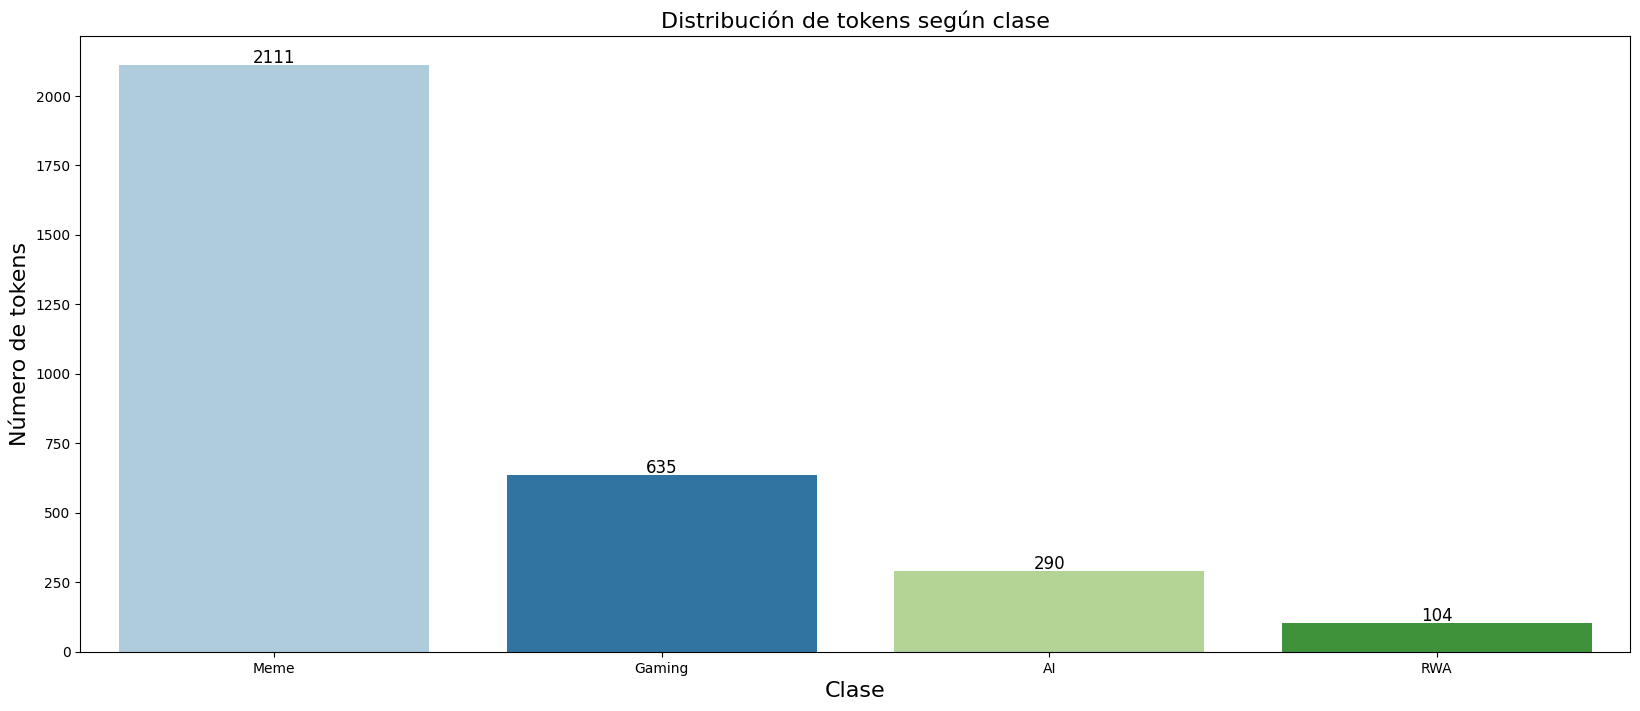

In [ ]:
#@title Distribución de tokens según categoría
df_clean['class'] = df_clean['class'].astype('category')

def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

fig, ax = plt.subplots(figsize=(20,8))
sns.countplot(data=df_clean,x="class",order = df_clean['class'].value_counts().index,palette="Paired")

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
ax.set_title("Distribución de tokens según clase",fontsize=16)
ax.set_ylabel("Número de tokens", fontsize=16)
ax.set_xlabel("Clase", fontsize=16)
wrap_labels(ax,10)
classList = ['Meme','Gaming', 'AI', 'RWA']  # Lista con las nuevas etiquetas
ax.set_xticklabels(classList)
plt.show()

C:\Users\tepha\AppData\Local\Temp\ipykernel_19428\2582503793.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_15_criptomonedasWL, y='watch_list_count', x='token', palette='Paired')
C:\Users\tepha\AppData\Local\Temp\ipykernel_19428\3517649807.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)


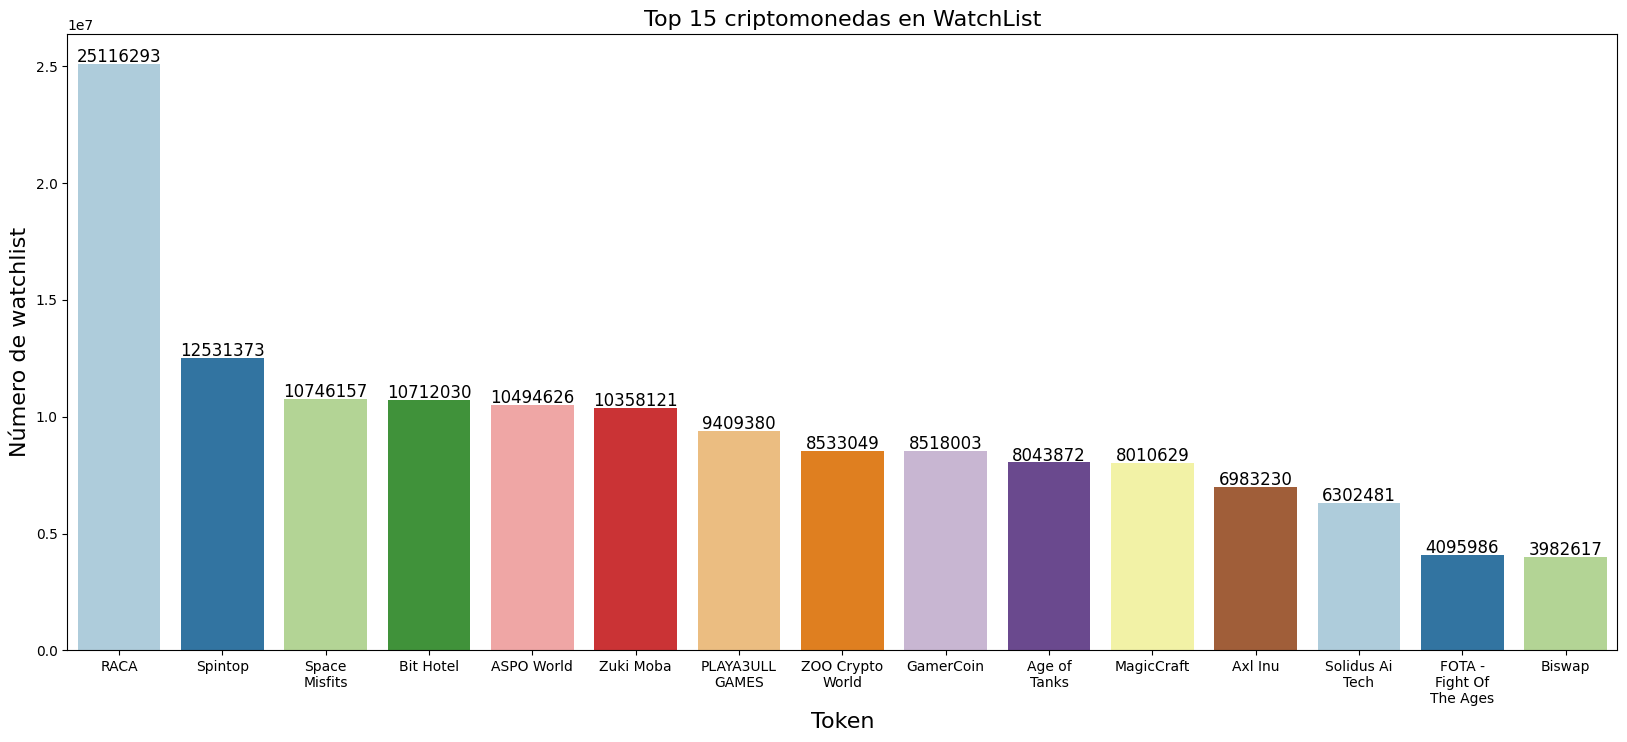

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
top_15_criptomonedasWL = df_clean.nlargest(15,"watch_list_count" )
sns.barplot(data=top_15_criptomonedasWL, y='watch_list_count', x='token', palette='Paired')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')
ax.set_title("Top 15 criptomonedas en WatchList",fontsize=16)
ax.set_ylabel("Número de watchlist", fontsize=16)
ax.set_xlabel("Token", fontsize=16)
wrap_labels(ax,10)
plt.show()

C:\Users\tepha\AppData\Local\Temp\ipykernel_19428\1279123552.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_criptomonedasX, x='followers_twitter', y='token', palette='rocket_r', ax = ax[0])
C:\Users\tepha\AppData\Local\Temp\ipykernel_19428\1279123552.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_criptomonedasT, x='followers_telegram', y='token', palette='rocket_r', ax = ax[1])
C:\Users\tepha\AppData\Local\Temp\ipykernel_19428\1279123552.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_cript

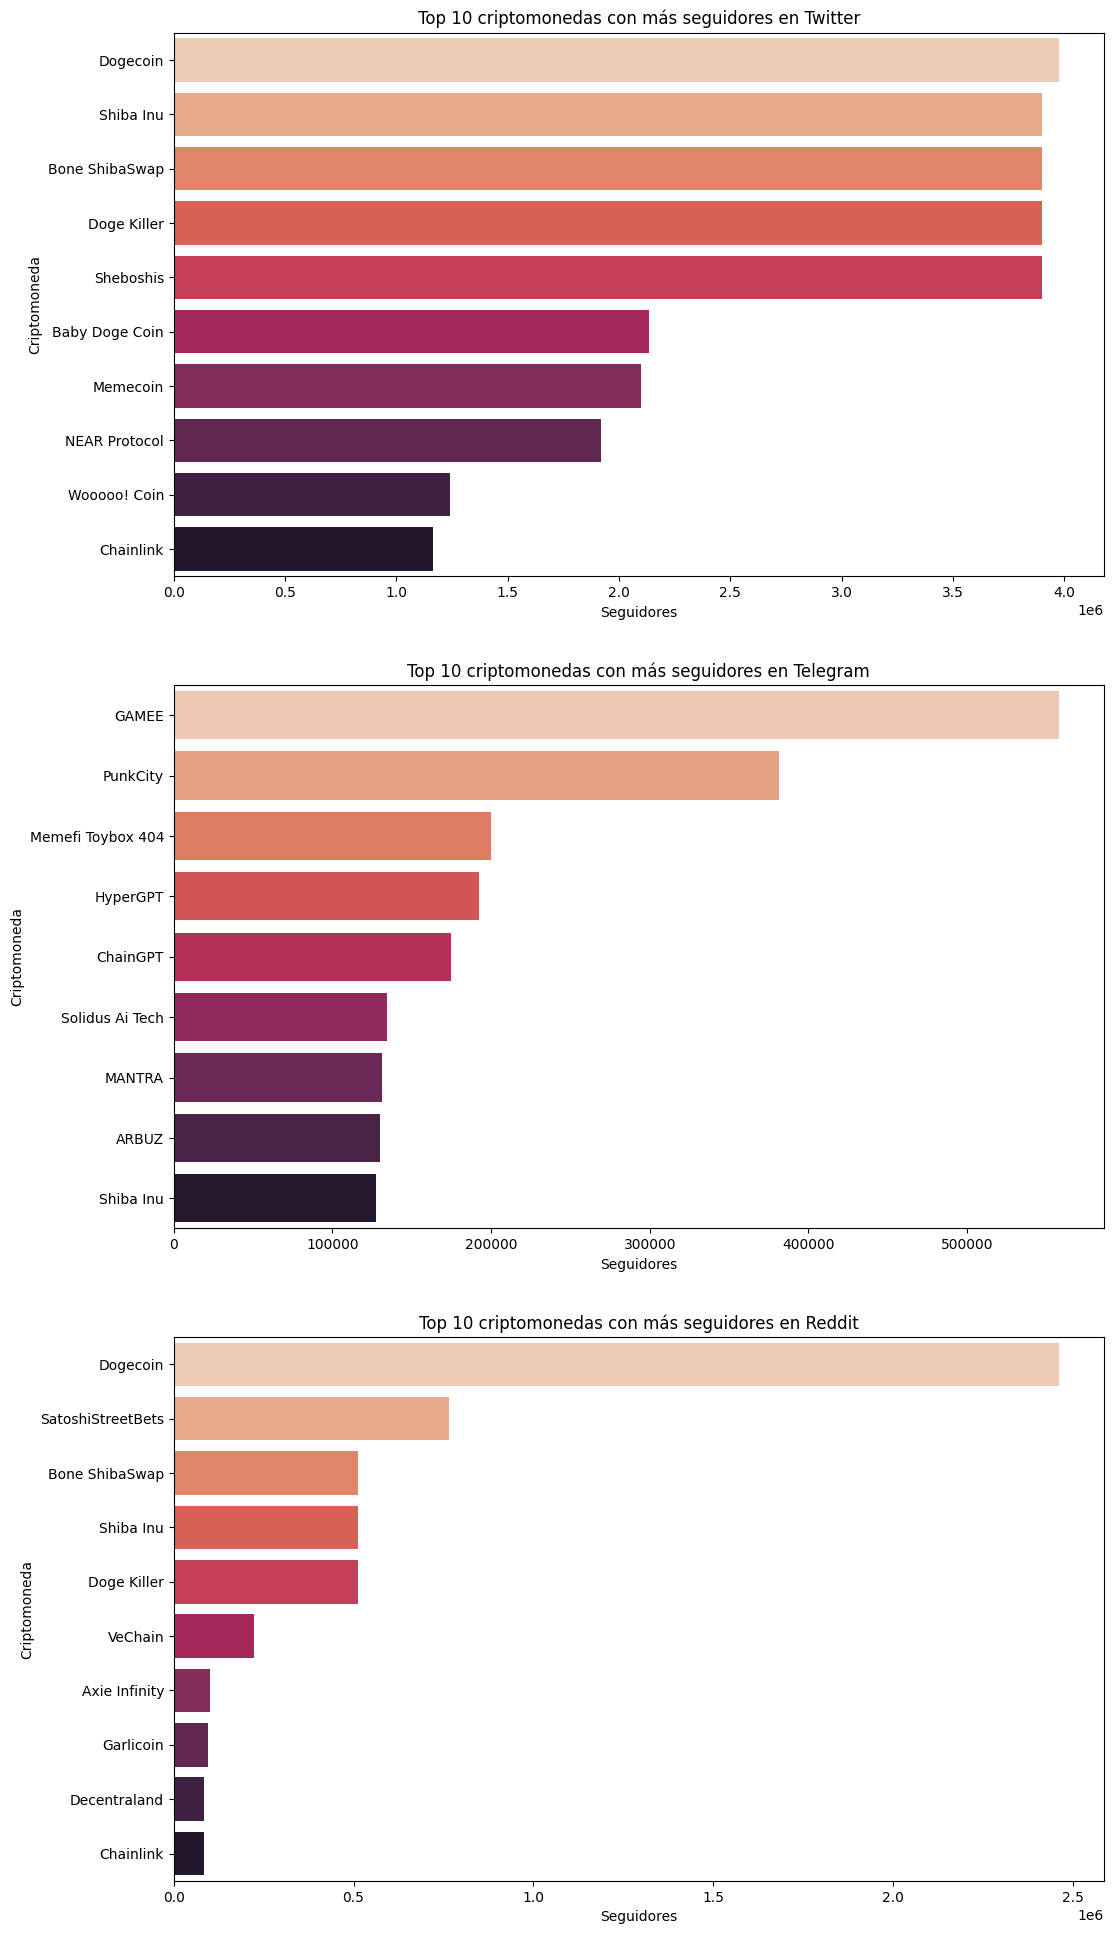

In [ ]:
#@title Distribución de tokens según followers en las redes sociales
top_10_criptomonedasX = df_clean.nlargest(10,"followers_twitter" )
top_10_criptomonedasT = df_clean.nlargest(10,"followers_telegram" )
top_10_criptomonedasR = df_clean.nlargest(10,"followers_reddit" )
fig, ax = plt.subplots(3,1,figsize=(12, 24))
sns.barplot(data=top_10_criptomonedasX, x='followers_twitter', y='token', palette='rocket_r', ax = ax[0])
ax[0].set_ylabel("Criptomoneda", fontsize=10)
ax[0].set_xlabel("Seguidores", fontsize=10)
ax[0].set_title("Top 10 criptomonedas con más seguidores en Twitter", fontsize=12)
sns.barplot(data=top_10_criptomonedasT, x='followers_telegram', y='token', palette='rocket_r', ax = ax[1])
ax[1].set_ylabel("Criptomoneda", fontsize=10)
ax[1].set_xlabel("Seguidores", fontsize=10)
ax[1].set_title("Top 10 criptomonedas con más seguidores en Telegram", fontsize=12)
sns.barplot(data=top_10_criptomonedasR, x='followers_reddit', y='token', palette='rocket_r', ax = ax[2])
ax[2].set_ylabel("Criptomoneda", fontsize=10)
ax[2].set_xlabel("Seguidores", fontsize=10)
ax[2].set_title("Top 10 criptomonedas con más seguidores en Reddit", fontsize=12)
plt.show()

C:\Users\tepha\AppData\Local\Temp\ipykernel_19428\807068630.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_criptomonedasXOld, x='age_days_twitter', y='token', palette='mako', ax = ax[0][0])
C:\Users\tepha\AppData\Local\Temp\ipykernel_19428\807068630.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_criptomonedasXNew, x='age_days_twitter', y='token', palette='mako', ax = ax[0][1])
C:\Users\tepha\AppData\Local\Temp\ipykernel_19428\807068630.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_criptom

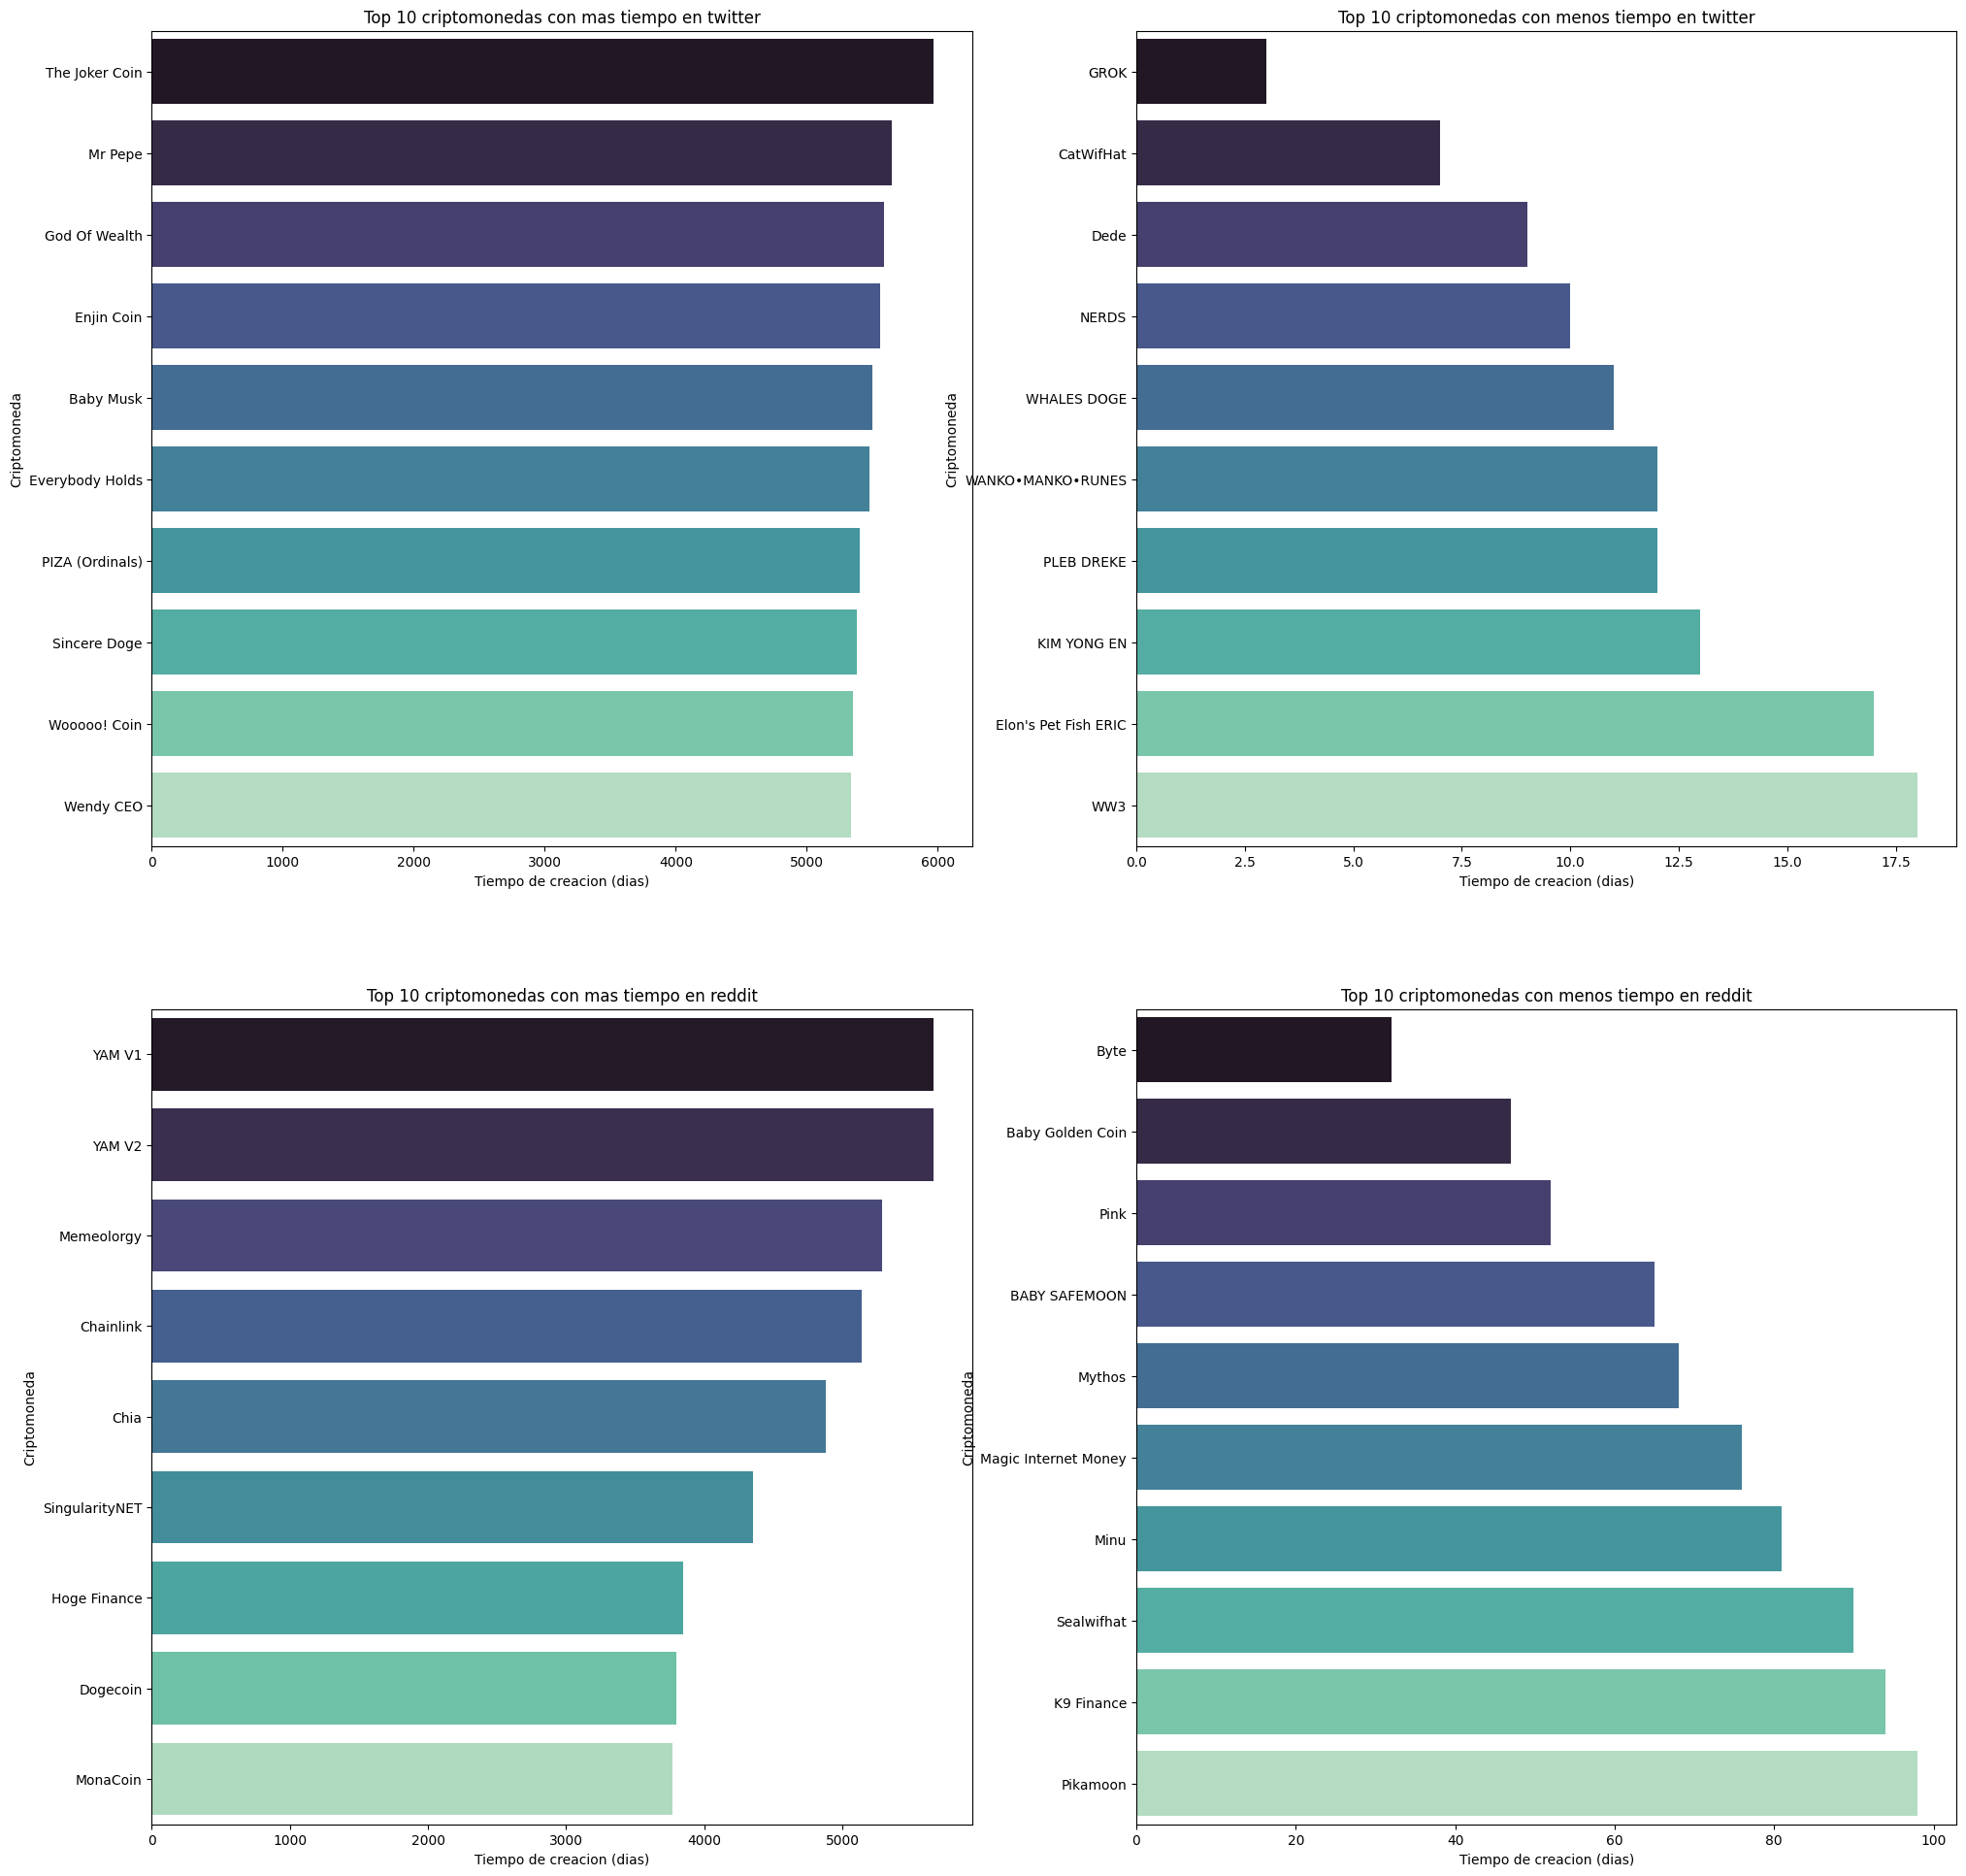

In [ ]:
#@title Distribución de tokens según antiguedad en las redes sociales
top_10_criptomonedasXOld = df_clean.nlargest(10,"age_days_twitter" )
top_10_criptomonedasXNew = df_clean[df_clean['age_days_twitter'] != 0].nsmallest(10,"age_days_twitter" )
top_10_criptomonedasROld = df_clean.nlargest(10,"age_days_reddit" )
top_10_criptomonedasRNew = df_clean[df_clean['age_days_reddit'] != 0].nsmallest(10,"age_days_reddit" )
fig, ax = plt.subplots(2,2,figsize=(24, 24))
sns.barplot(data=top_10_criptomonedasXOld, x='age_days_twitter', y='token', palette='mako', ax = ax[0][0])
ax[0][0].set_ylabel("Criptomoneda", fontsize=10)
ax[0][0].set_xlabel("Tiempo de creacion (dias)", fontsize=10)
ax[0][0].set_title("Top 10 criptomonedas con mas tiempo en twitter", fontsize=12)
sns.barplot(data=top_10_criptomonedasXNew, x='age_days_twitter', y='token', palette='mako', ax = ax[0][1])
ax[0][1].set_ylabel("Criptomoneda", fontsize=10)
ax[0][1].set_xlabel("Tiempo de creacion (dias)", fontsize=10)
ax[0][1].set_title("Top 10 criptomonedas con menos tiempo en twitter", fontsize=12)
sns.barplot(data=top_10_criptomonedasROld, x='age_days_reddit', y='token', palette='mako', ax = ax[1][0])
ax[1][0].set_ylabel("Criptomoneda", fontsize=10)
ax[1][0].set_xlabel("Tiempo de creacion (dias)", fontsize=10)
ax[1][0].set_title("Top 10 criptomonedas con mas tiempo en reddit", fontsize=12)
sns.barplot(data=top_10_criptomonedasRNew, x='age_days_reddit', y='token', palette='mako', ax = ax[1][1])
ax[1][1].set_ylabel("Criptomoneda", fontsize=10)
ax[1][1].set_xlabel("Tiempo de creacion (dias)", fontsize=10)
ax[1][1].set_title("Top 10 criptomonedas con menos tiempo en reddit", fontsize=12)

plt.show()

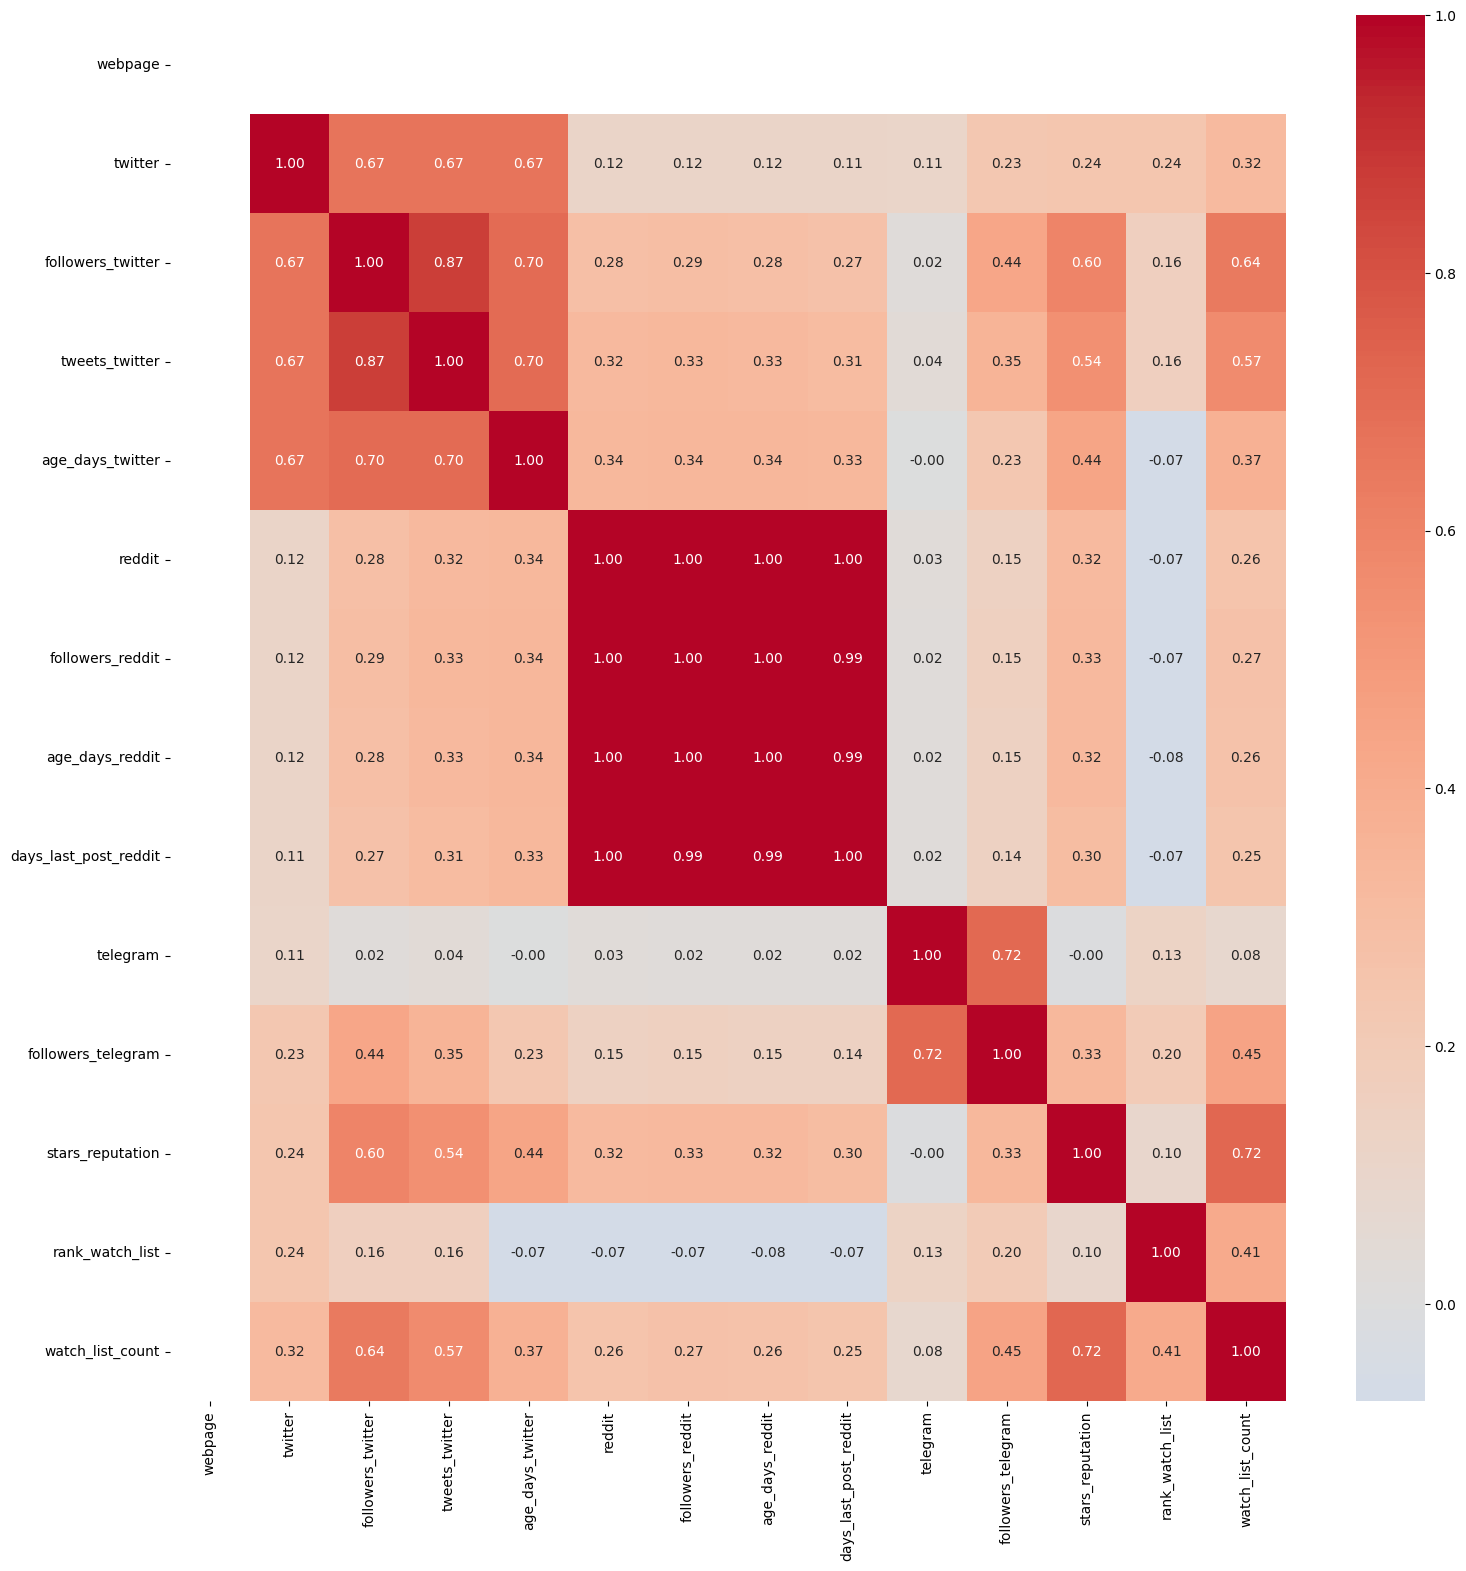

In [ ]:
#@title heatmap de correlacion
plt.figure(figsize=(18, 18))
lnum = df_clean.select_dtypes(include=np.number).columns.tolist()
df_num=df_clean[lnum].copy()
sns.heatmap(df_num.corr(method = 'spearman'), annot = True, fmt = '.2f', cmap = 'coolwarm', center = 0)
plt.show()